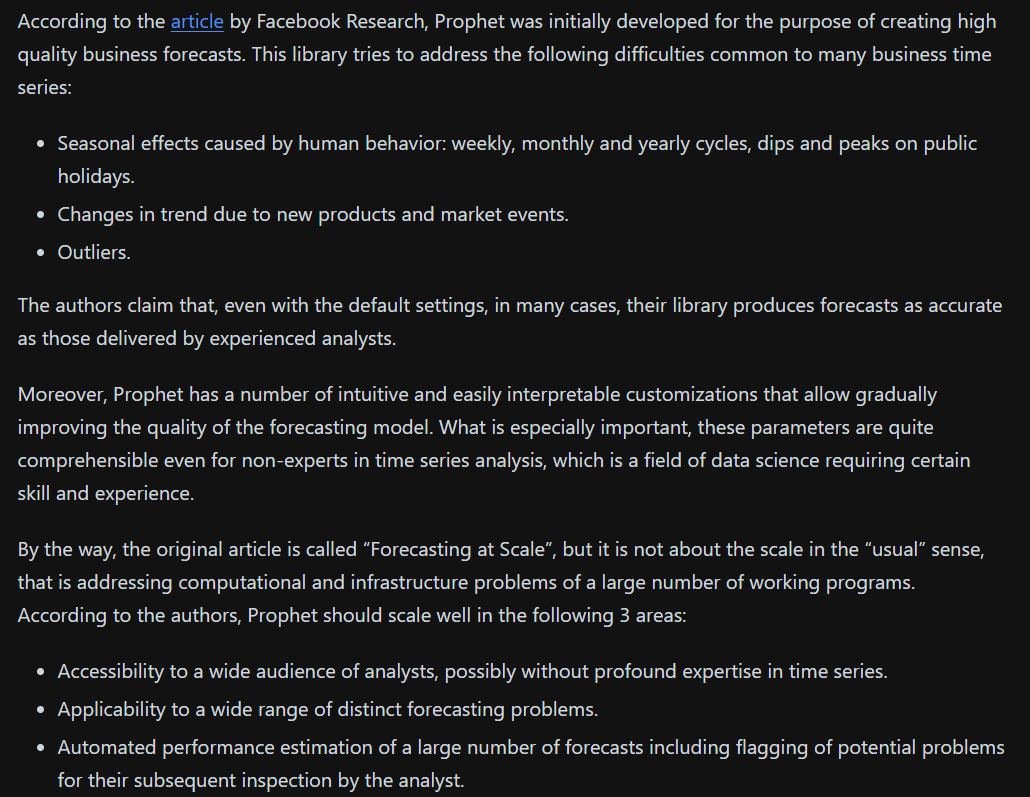

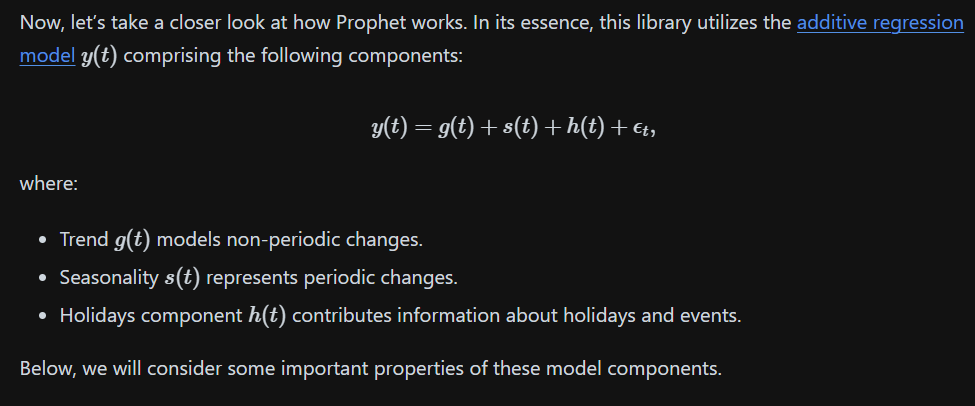

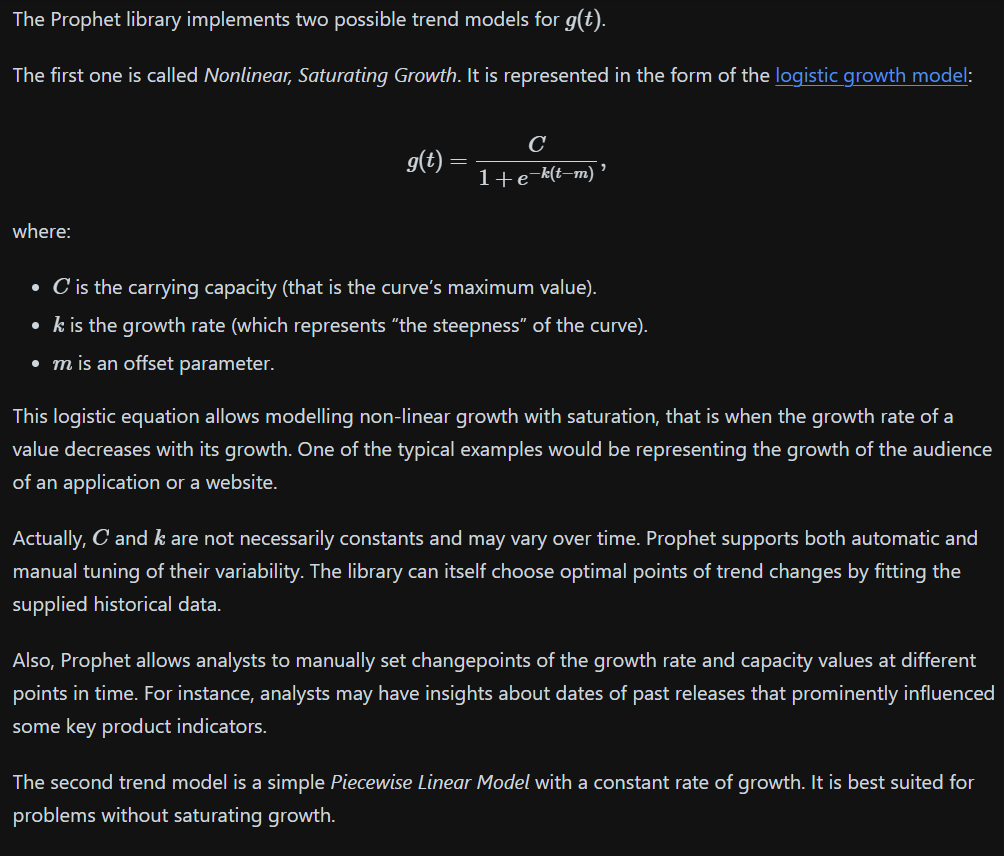

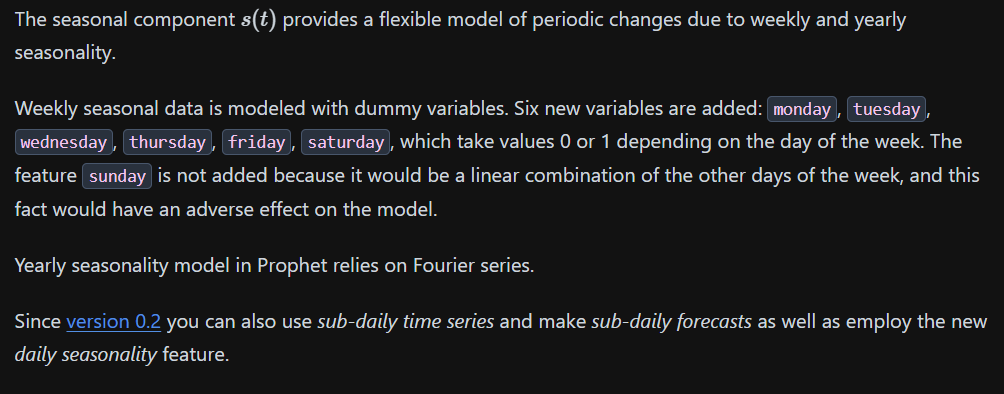

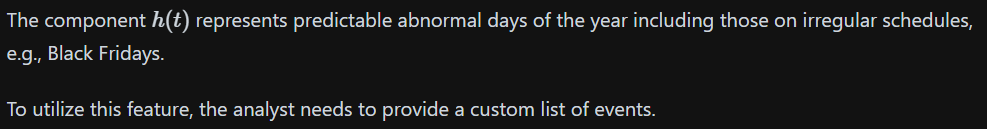

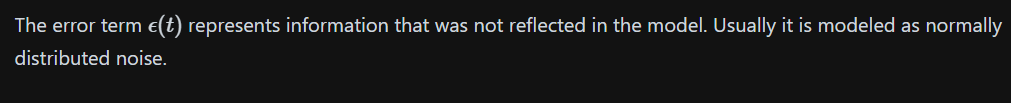

In [1]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'

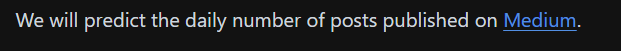

In [40]:
import gdown 

def download_file_from_gdrive(file_url, filename, dest_path, overwrite=False):
    """
    Downloads a file from GDrive given an URL
    :param file_url: a string formated as https://drive.google.com/uc?id=<file_id>
    :param: the desired file name
    :param: the desired folder where the file will be downloaded to
    :param overwrite: whether to overwrite the file if it already exists
    """
    file_exists = Path(dest_path + "\\" + filename).exists()

    if not file_exists:
        gdown.download(file_url, dest_path, quiet=False)

In [41]:
FILE_URL = "https://drive.google.com/uc?id=1et3FfGQzm_lw0AWtZ0125TKKbD6dTwdi"
DEST_PATH = "C:\\Users\\mateu\\mlcourse.AI\\Topic09\\medium"
FILE_NAME = "medium_posts.csv"

download_file_from_gdrive(file_url=FILE_URL, filename = FILE_NAME, dest_path=DEST_PATH)

df = pd.read_csv(DEST_PATH + "\\" + FILE_NAME,  sep="\t")

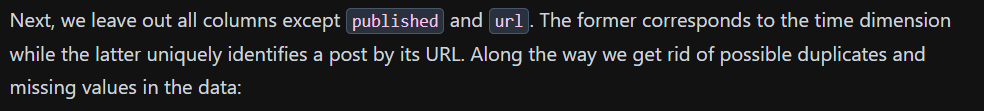

In [42]:
df = df[["published", "url"]].dropna().drop_duplicates()

In [43]:
df.sort_values(by=["published"]).head(n=2)

,published,url
50931,1970-01-01 00:00:00.001Z,https://medium.com/iiot
40243,1970-01-01 00:00:00.001Z,https://medium.com/@ikaella/melon-rebranding-b...


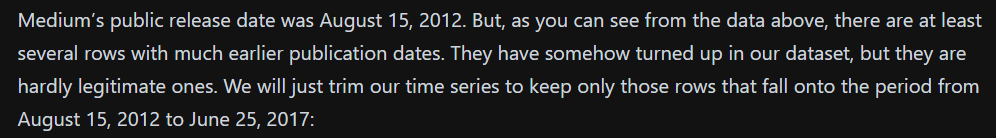

In [44]:
df = df[
    (df["published"] > "2012-08-15") & (df["published"] < "2017-06-26")
].sort_values(by=["published"])
df.head(n=3)

,published,url
24630,2012-08-15 00:25:03.373Z,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419Z,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502Z,https://medium.com/i-m-h-o/the-world-is-social...


In [45]:
df.tail(n=3)

,published,url
62122,2017-06-25 23:36:01.171Z,https://medium.com/push-the-pace/the-official-...
72471,2017-06-25 23:41:48.295Z,https://medium.com/parti-xyz-developers/%EA%B4...
83283,2017-06-25 23:51:43.000Z,http://www.johanr.com/blog/people-support-dreams


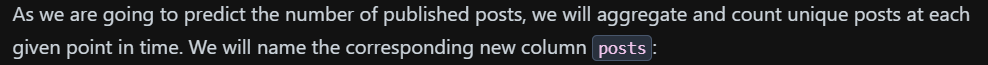

In [53]:
df['published'] = pd.to_datetime(df['published'])
#df.set_index('publsihed', inplace=True)

In [54]:
aggr_df = df.groupby("published")[["url"]].count()
aggr_df.columns = ["posts"]

In [55]:
aggr_df.head(n=3)

,posts
published,
2012-08-15 00:25:03.373000+00:00,1
2012-08-15 00:25:29.419000+00:00,1
2012-08-15 00:34:59.502000+00:00,1


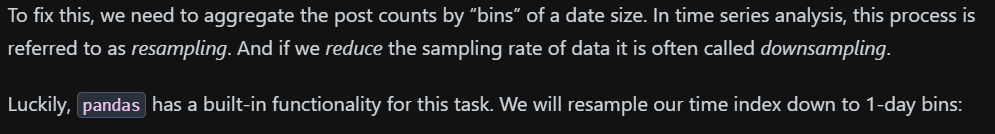

In [56]:
daily_df = aggr_df.resample("D").apply(sum)
daily_df.head(n=3)

,posts
published,
2012-08-15 00:00:00+00:00,16
2012-08-16 00:00:00+00:00,11
2012-08-17 00:00:00+00:00,4


<h3>Exploatory visual analysis<h3>

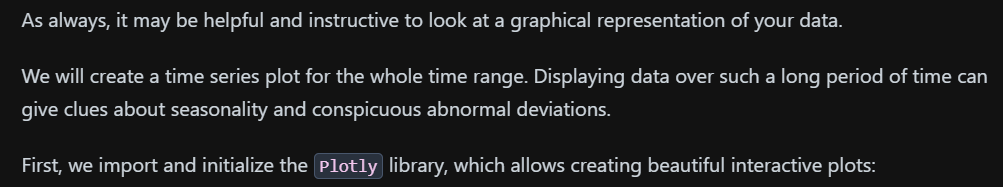

In [57]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
from IPython.display import display, IFrame

# Initialize plotly
init_notebook_mode(connected=True)

In [63]:
def plotly_df(df, title="", width=800, height=500):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode="lines")
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)

    # in a Jupyter Notebook, the following should work
    iplot(fig, show_link=False)

    # in a Jupyter Book, we save a plot offline and then render it with IFrame
    plot_path = f"C:\\Users\\mateu\\mlcourse.AI\\Topic09\\plots\\{title}.html".replace(" ", "_")
    plot(fig, filename=plot_path, show_link=False, auto_open=False);
    display(IFrame(plot_path, width=width, height=height))

In [65]:
plotly_df(daily_df, title="Posts on Medium (daily)")

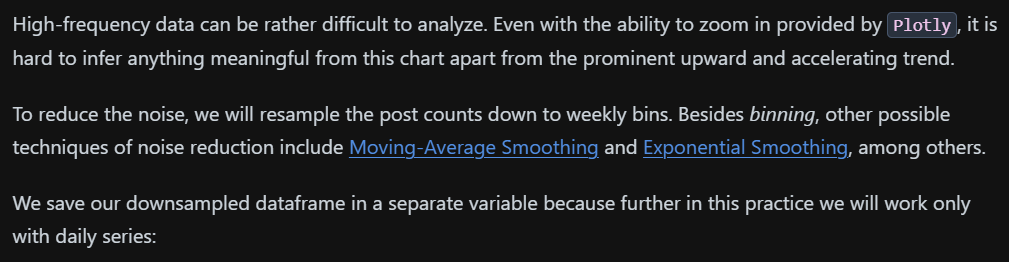

In [66]:
weekly_df = daily_df.resample("W").apply(sum)

In [67]:
plotly_df(weekly_df, title="Posts on Medium (weekly)")

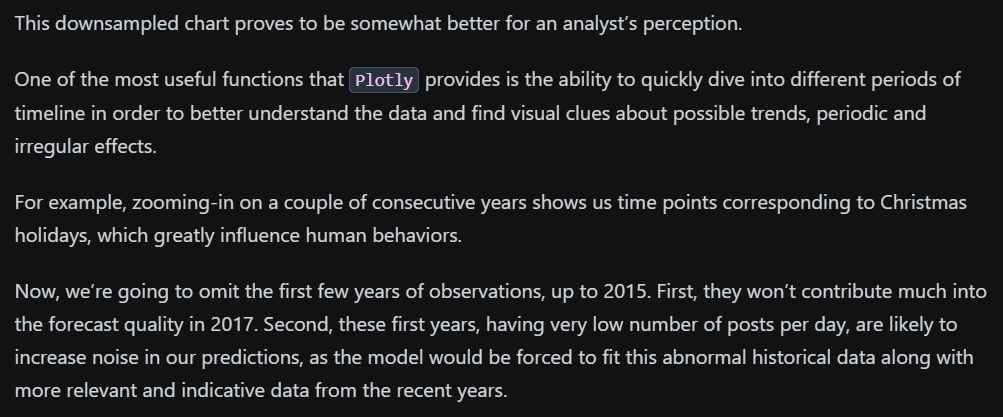

In [68]:
daily_df = daily_df.loc[daily_df.index >= "2015-01-01"]
daily_df.head(n=3)

,posts
published,
2015-01-01 00:00:00+00:00,8
2015-01-02 00:00:00+00:00,11
2015-01-03 00:00:00+00:00,11


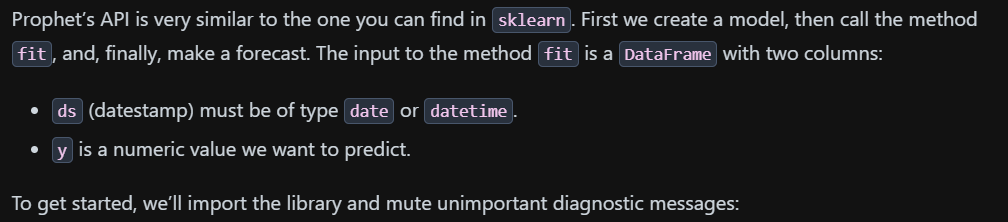

In [69]:
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

In [70]:
df = daily_df.reset_index()
df.columns = ["ds", "y"]
# converting timezones (issue https://github.com/facebook/prophet/issues/831)
df["ds"] = df["ds"].dt.tz_convert(None)
df.tail(n=3)

,ds,y
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


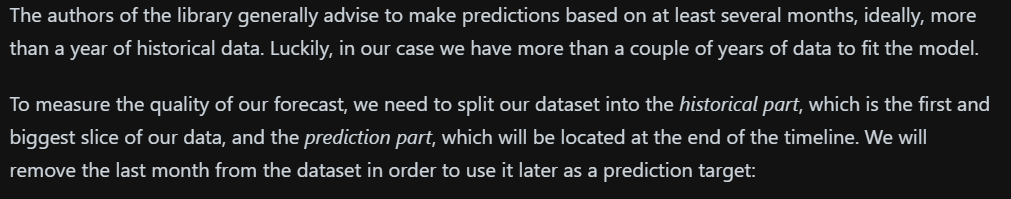

In [71]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


In [72]:
m = Prophet()
m.fit(train_df);

12:17:00 - cmdstanpy - INFO - Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing


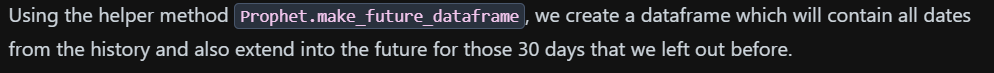

In [73]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
904,2017-06-23
905,2017-06-24
906,2017-06-25


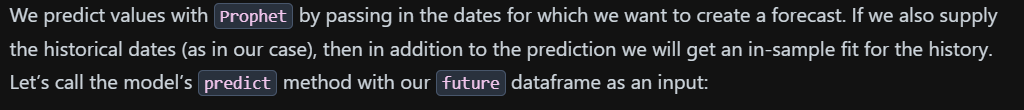

In [74]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
904,2017-06-23,276.295368,255.122640,303.449829,275.909513,276.710220,2.479494,2.479494,2.479494,3.477352,3.477352,3.477352,-0.997858,-0.997858,-0.997858,0.0,0.0,0.0,278.774862
905,2017-06-24,276.997167,216.720060,266.719983,276.577482,277.427099,-34.826832,-34.826832,-34.826832,-34.026287,-34.026287,-34.026287,-0.800544,-0.800544,-0.800544,0.0,0.0,0.0,242.170335
906,2017-06-25,277.698965,220.918528,270.961284,277.240210,278.165537,-31.186097,-31.186097,-31.186097,-30.582196,-30.582196,-30.582196,-0.603901,-0.603901,-0.603901,0.0,0.0,0.0,246.512868


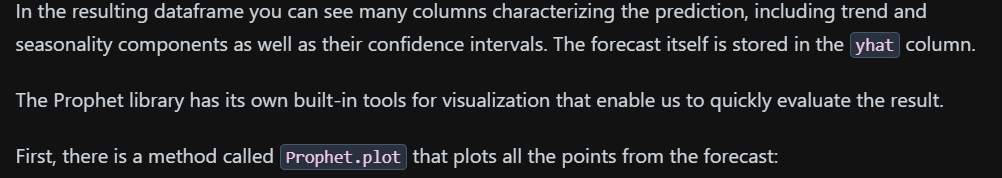

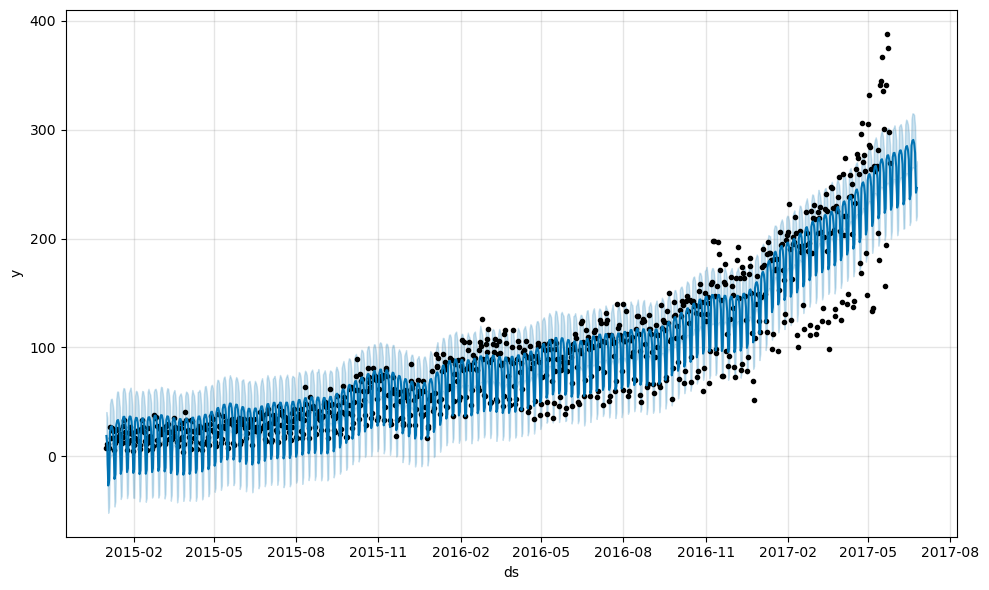

In [75]:
m.plot(forecast);

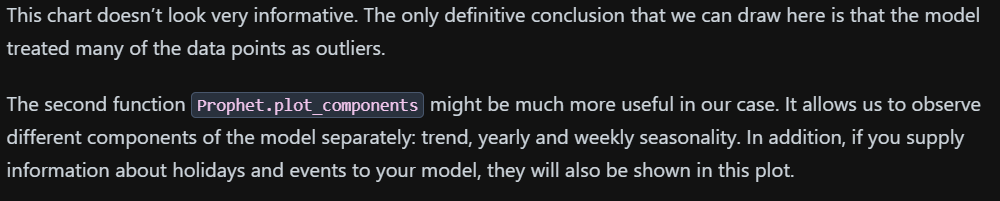

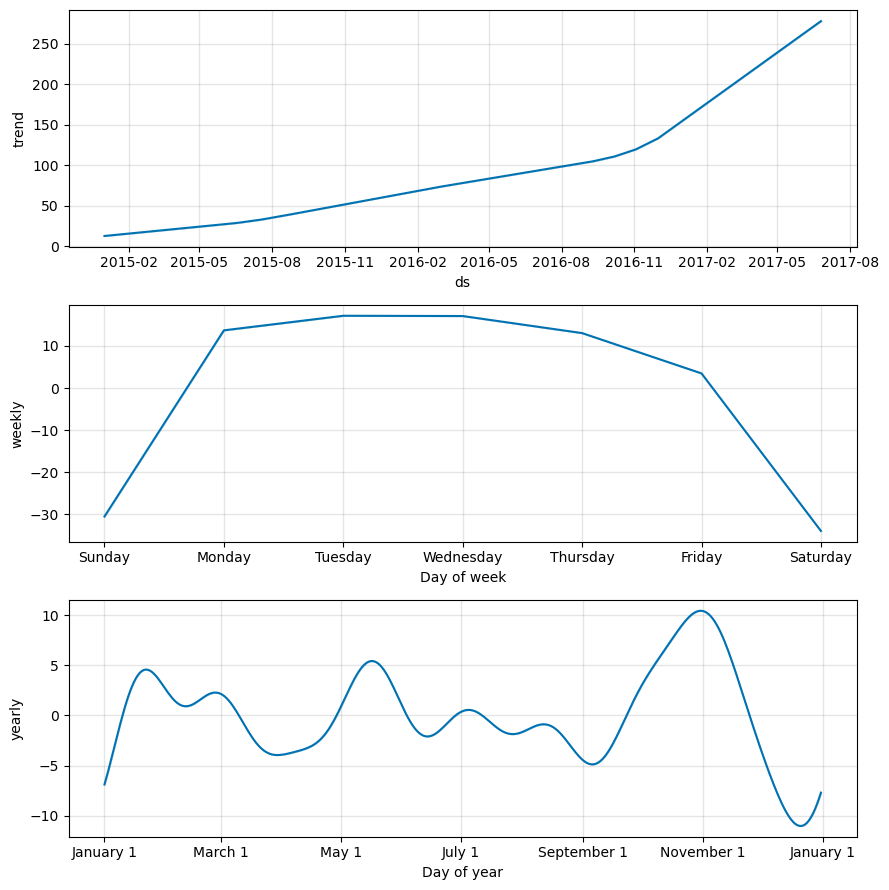

In [76]:
m.plot_components(forecast);

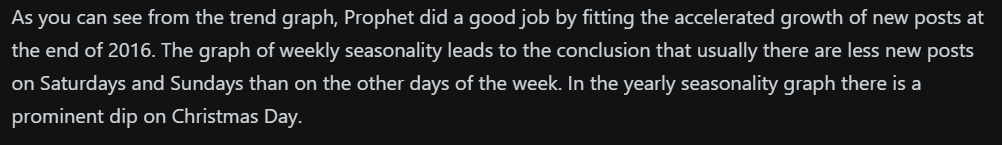

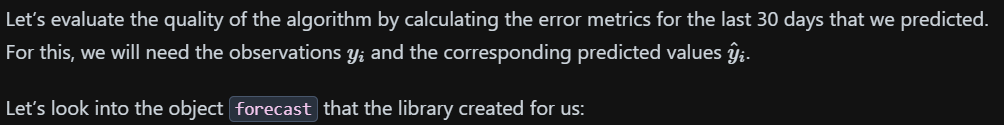

In [77]:
print(", ".join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


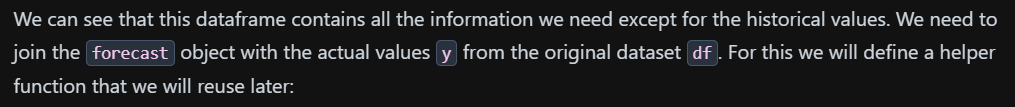

In [78]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.

       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds")
    )

In [79]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-23,278.774862,255.122640,303.449829,421
2017-06-24,242.170335,216.720060,266.719983,277
2017-06-25,246.512868,220.918528,270.961284,253


In [80]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.

       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """

    # Make a copy
    df = df.copy()

    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]

    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model.

    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]

    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {"MAPE": error_mean("p"), "MAE": error_mean("e")}

In [81]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 22.703780793420673
MAE 70.3488536200194


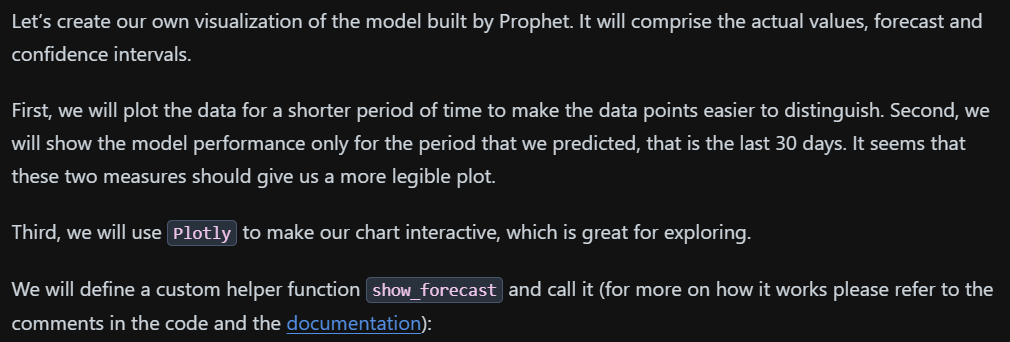

In [83]:
def show_forecast(cmp_df, num_predictions, num_values, title, width=800, height=500):
    """Visualize the forecast."""

    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode="lines")
        args.update(kwargs)
        return go.Scatter(**args)

    lower_bound = create_go(
        "Lower Bound",
        "yhat_lower",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
    )
    upper_bound = create_go(
        "Upper Bound",
        "yhat_upper",
        num_predictions,
        line=dict(width=0),
        marker=dict(color="gray"),
        fillcolor="rgba(68, 68, 68, 0.3)",
        fill="tonexty",
    )
    forecast = create_go(
        "Forecast", "yhat", num_predictions, line=dict(color="rgb(31, 119, 180)")
    )
    actual = create_go("Actual", "y", num_values, marker=dict(color="red"))

    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title="Posts"), title=title, showlegend=False)
    fig = go.Figure(data=data, layout=layout)

    # in a Jupyter Notebook, the following should work
    iplot(fig, show_link=False)

    # in a Jupyter Book, we save a plot offline and then render it with IFrame
    plot_path = f"C:\\Users\\mateu\\mlcourse.AI\\Topic09\\plots\\{title}.html".replace(" ", "_")
    plot(fig, filename=plot_path, show_link=False, auto_open=False);
    display(IFrame(plot_path, width=width, height=height))


show_forecast(cmp_df, prediction_size, 100, "New posts on Medium")

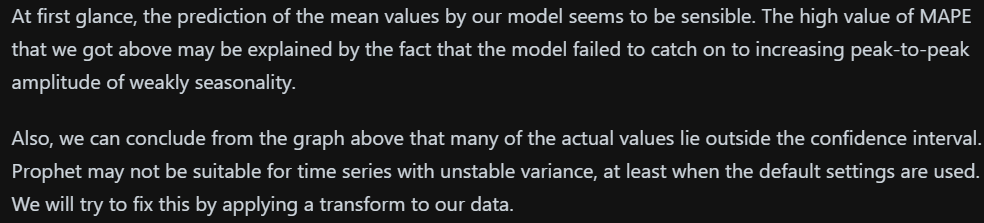

<h3>Box-Cox transformersion<h3>

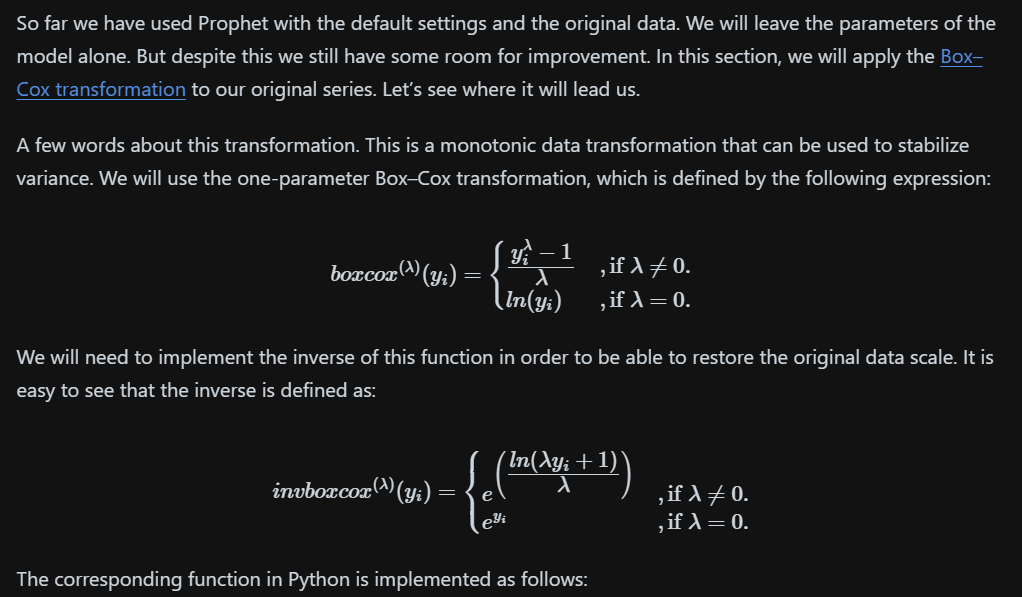

In [84]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [85]:
train_df2 = train_df.copy().set_index("ds")

In [86]:
train_df2["y"], lambda_prophet = stats.boxcox(train_df2["y"])
train_df2.reset_index(inplace=True)

In [87]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:59 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
for column in ["yhat", "yhat_lower", "yhat_upper"]:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

In [89]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 11.831420404573487
MAE 40.0859516016639


In [90]:
show_forecast(cmp_df, prediction_size, 100, "No transformations")
show_forecast(cmp_df2, prediction_size, 100, "Box–Cox transformation")